In [1]:
%load_ext autoreload


In [2]:
# supress warning message

import warnings
warnings.filterwarnings("ignore")
# to print warnings only once
# warnings.filterwarnings(action='once')


In [3]:
%matplotlib inline
# https://github.com/ternaus/TernausNet
from pycocotools.coco import COCO
from pycocotools import mask as cocomask
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [4]:
%autoreload
from dataset.dataset import TrainImageDataset, TestImageDataset
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler

import dataset.transform_and_augment as trans_aug
import os
from multiprocessing import cpu_count

from dataset.dataset import TrainImageDataset, TestImageDataset
import multiprocessing

In [5]:
!pwd

/home/webwerks/patricia/my-projects/github/Segmentation/dev


In [6]:
# change the working dirctory
project_dir = "/home/webwerks/patricia/my-projects/github/Segmentation"
os.chdir(project_dir)

data_directory = "data/"
annotation_file_template = "{}/{}/annotation{}.json"

TRAIN_IMAGES_DIRECTORY = "data/train/images"
TRAIN_ANNOTATIONS_PATH = "data/train/annotation.json"
TRAIN_ANNOTATIONS_SMALL_PATH = "data/train/annotation-small.json"

VAL_IMAGES_DIRECTORY = "data/val/images"
VAL_ANNOTATIONS_PATH = "data/val/annotation.json"
VAL_ANNOTATIONS_SMALL_PATH = "data/val/annotation-small.json"

In [7]:
# create a train dataset
train_coco = COCO(os.path.join(TRAIN_ANNOTATIONS_SMALL_PATH))
# create a val dataset
val_coco = COCO(os.path.join(VAL_ANNOTATIONS_SMALL_PATH))


loading annotations into memory...
Done (t=1.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [8]:
input_img_resize = (224, 224)  # The resize size of the input images of the neural net
output_img_resize = (224, 224) # The resize size of the output images of the neural net

batch_size = 2
epochs = 50
threshold = 0.5
validation_size = 0.2
sample_size = None  # Put 'None' to work on full dataset or a value between 0 and 1

# -- Optional parameters
threads = cpu_count()
use_cuda = torch.cuda.is_available()

In [9]:
%autoreload
from dataset.dataset import TrainImageDataset, TestImageDataset
# train_ds = TrainImageDataset(img_dir = VAL_IMAGES_DIRECTORY , cocodataset = val_coco, y_data = None, 
#                              input_img_resize = input_img_resize,output_img_resize = output_img_resize, X_transform=trans_aug.augment_img)

# train_loader = DataLoader(train_ds, batch_size,sampler=RandomSampler(train_ds), num_workers=threads,pin_memory=use_cuda)

# valid_ds = TrainImageDataset(img_dir = VAL_IMAGES_DIRECTORY, cocodataset = val_coco, y_data = None, 
#                              input_img_resize = input_img_resize, output_img_resize = output_img_resize, X_transform=trans_aug.augment_img)

# valid_loader = DataLoader(valid_ds, batch_size,
#                           sampler=SequentialSampler(valid_ds),
#                           num_workers=threads,
#                           pin_memory=use_cuda)

train_ds = TrainImageDataset(img_dir = VAL_IMAGES_DIRECTORY , cocodataset = val_coco, y_data = None, 
                             input_img_resize = input_img_resize,output_img_resize = output_img_resize, X_transform=None)

train_loader = DataLoader(train_ds, batch_size,sampler=RandomSampler(train_ds), num_workers=threads,pin_memory=use_cuda)

valid_ds = TrainImageDataset(img_dir = VAL_IMAGES_DIRECTORY, cocodataset = val_coco, y_data = None, 
                             input_img_resize = input_img_resize, output_img_resize = output_img_resize, X_transform=None)

valid_loader = DataLoader(valid_ds, batch_size,
                          sampler=SequentialSampler(valid_ds),
                          num_workers=threads,
                          pin_memory=use_cuda)

print("Training on {} samples and validating on {} samples ".format(len(train_loader.dataset), len(valid_loader.dataset)))

Training on 1820 samples and validating on 1820 samples 


In [19]:
# test dataset
TEST_IMAGES_DIRECTORY = "data/test"
test_ds = TestImageDataset(X_data = TEST_IMAGES_DIRECTORY, img_dir = TEST_IMAGES_DIRECTORY)
test_loader = DataLoader(test_ds, batch_size,
                         sampler=SequentialSampler(test_ds),
                         num_workers=threads,
                         pin_memory=use_cuda)

In [20]:
from models.train_callbacks import TensorboardVisualizerCallback, TensorboardLoggerCallback, ModelSaverCallback
from models.test_callbacks import PredictionsSaverCallback
from models import helpers
script_dir = os.path.dirname(project_dir)
# Training callbacks
tb_viz_cb = TensorboardVisualizerCallback(os.path.join(script_dir, 'logs/tb_viz'))
tb_logs_cb = TensorboardLoggerCallback(os.path.join(script_dir, 'logs/tb_logs'))
model_saver_cb = ModelSaverCallback(os.path.join(script_dir,'logs/tb_logs/model_' +
                                                 helpers.get_model_timestamp()), verbose=True)


In [21]:
%autoreload
from models import classifier
from models import unet
import torch.optim as optim

epochs = 25
net = unet.UNet16()
net = unet.freezing_pretrained_layers(model = net, freeze = False)
# net = unet.UNetOriginal((3, 300,300))
classifier = classifier.UnetClassifier(net, epochs)
# Train the classifier

classifier.train(train_loader, valid_loader, 
                 epochs, callbacks=[tb_viz_cb, tb_logs_cb, model_saver_cb])

Epochs 2/10:   0%|          | 0/910 [?]                      

train_loss = 6.274875, train_acc = 0.006909
val_loss   = 7.078900, val_acc   = 0.000065
Time elapsed = 100s


Epochs 3/10:   0%|          | 0/910 [?]                      

train_loss = 7.078900, train_acc = 0.000058
val_loss   = 7.078900, val_acc   = 0.000065
Time elapsed = 102s


Epochs 4/10:   0%|          | 0/910 [?]                      

train_loss = 7.078900, train_acc = 0.000059
val_loss   = 7.078900, val_acc   = 0.000065
Time elapsed = 104s


Epochs 4/10: 100%|██████████| 910/910 [00:00, loss=8.10703, dice_coeff=0.00004] 


Epoch     3: reducing learning rate of group 0 to 1.0000e-04.


Epochs 5/10:   0%|          | 0/910 [?]

train_loss = 7.078900, train_acc = 0.000056
val_loss   = 7.078900, val_acc   = 0.000065
Time elapsed = 102s


Epochs 6/10:   0%|          | 0/910 [?]                      

train_loss = 7.078900, train_acc = 0.000060
val_loss   = 7.078900, val_acc   = 0.000065
Time elapsed = 102s


Epochs 7/10:   0%|          | 0/910 [?]                      

train_loss = 7.078900, train_acc = 0.000058
val_loss   = 7.078900, val_acc   = 0.000065
Time elapsed = 102s


Epochs 7/10: 100%|██████████| 910/910 [00:00, loss=8.11081, dice_coeff=0.00004] 


Epoch     6: reducing learning rate of group 0 to 1.0000e-05.


Epochs 8/10:   0%|          | 0/910 [?]

train_loss = 7.078900, train_acc = 0.000063
val_loss   = 7.078900, val_acc   = 0.000065
Time elapsed = 102s


Epochs 9/10:   0%|          | 0/910 [?]                      

train_loss = 7.078900, train_acc = 0.000058
val_loss   = 7.078900, val_acc   = 0.000065
Time elapsed = 100s


Epochs 10/10:   0%|          | 0/910 [?]                     

train_loss = 7.078900, train_acc = 0.000057
val_loss   = 7.078900, val_acc   = 0.000065
Time elapsed = 102s


Epochs 10/10: 100%|██████████| 910/910 [00:00, loss=5.78152, dice_coeff=0.00006] 


Epoch     9: reducing learning rate of group 0 to 1.0000e-06.
train_loss = 7.078900, train_acc = 0.000068
val_loss   = 7.078900, val_acc   = 0.000065
Time elapsed = 104s
Model saved in /home/webwerks/patricia/my-projects/github/logs/tb_logs/model_2020-01-21_13h49


In [ ]:
origin_img_size = 224
pred_saver_cb = PredictionsSaverCallback(os.path.join(project_dir, 'data/output/submit.csv.gz'),
                                             origin_img_size, threshold)

In [ ]:
# # Predict & save
# classifier.predict(test_loader, callbacks=[pred_saver_cb])
# pred_saver_cb.close_saver()

In [ ]:
## IoU

import torch
import numpy as np 


# PyTroch version

SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch
    
    
# Numpy version
# Well, it's the same function, so I'm going to omit the comments

def iou_numpy(outputs: np.array, labels: np.array):
    outputs = outputs.squeeze(1)
    
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded  # Or thresholded.mean()

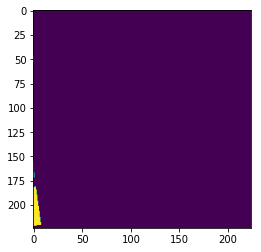

In [31]:
## code for change detection
# reference https://github.com/cbsudux/Mumbai-slum-segmentation/blob/b42c473af9dbd422cfa290d056125dc0174b01cb/slums/change_detection.py#L122
# mask_1,mask_2,diff = cal_diff(mask_1,mask_2,files,image_1,image_2,results_1,results_2)
image_1, mask_1 = train_ds.__getitem__(8)
plt.imshow(mask_1)

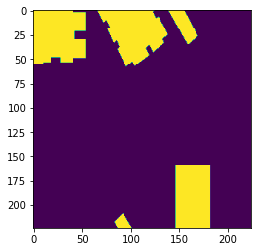

In [28]:
image_2, mask_2 = train_ds.__getitem__(2)
plt.imshow(mask_2)

M1 area : 7941
M2 area : 207
Diff in area : 8142
Change  102.53116735927466 %


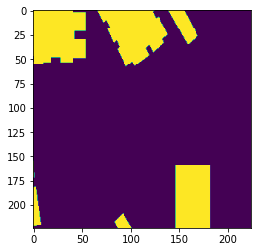

In [38]:
import cv2
from skimage import measure
 

def get_area(mask):
    area = measure.regionprops(mask.astype(np.uint8))	
    area = [prop.area for prop in area][0]
    return area

# def cal_diff(mask_1,mask_2,files,image_1,image_2,results_1,results_2):
def cal_diff(mask_1,mask_2, plt):
#     import pdb; pdb.set_trace()
    mask_1 = mask_1.numpy()
    mask_2 = mask_2.numpy()
    len_1 = mask_1.shape[1]
    len_2 = mask_2.shape[1]

#     #Number of detections might be unequal
#     #combine mask channels.
#     m1 = np.zeros((mask_1.shape[:1]))
#     for i in range(len_1):
#         m1 = np.logical_or(m1,mask_1[:,i])

#     m2 = np.zeros((mask_2.shape[:1]))
#     for i in range(len_2):
#         m2 = np.logical_or(m2,mask_2[:,i])


    #Calculate total area covered by mask_1
    mask_1_area = get_area(mask_1)
    mask_2_area = get_area(mask_2)

#     m1 = m1.astype(np.uint8)	
#     m2 = m2.astype(np.uint8)	

#     print(m1.shape)
#     print(m2.shape)

    diff = cv2.absdiff(mask_1,mask_2)
    plt.imshow(diff)
    diff_area = get_area(diff)

    print("M1 area :",mask_1_area)
    print("M2 area :",mask_2_area)
    print("Diff in area :",diff_area)

    max_area = max(mask_1_area,mask_2_area)

    d = diff_area/max_area
    # 	if mask_1_area > mask_2_area:
    # 		print(files[0],' greater area')
    # 	else:
    # 		print(files[1],' greater area')

    print('Change ',d*100,'%')

    return mask_1, mask_2, diff

mask_o1,mask_02,diff = cal_diff(mask_2,mask_1, plt)

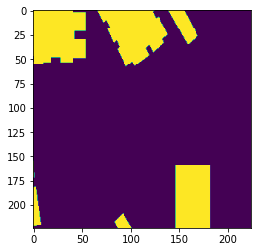

In [37]:
plt.imshow(mask_1)
# plt.axis('off')
plt.savefig('./change_det/mask_1.png',bbox_inches='tight')
#plt.show()

plt.imshow(mask_2)
# plt.axis('off')
plt.savefig('./change_det/mask_2.png',bbox_inches='tight')
#plt.show()

plt.imshow(diff)
# plt.axis('off')
plt.savefig('./change_det/change.png',bbox_inches='tight')
#plt.show()

In [36]:
!pwd


/home/webwerks/patricia/my-projects/github/Segmentation


In [41]:
mask_1.numpy().astype(np.uint8)[0][2]

0

In [44]:
print(mask_1.sum())
print(mask_1.numpy().astype(np.uint8).sum())

tensor(247.7711)
207


In [45]:
print(mask_2.sum())
print(mask_2.numpy().astype(np.uint8).sum())

tensor(8232.3340)
7941
